In [1]:
import sys
sys.path.append("..")
import math
import torch
from torch import tensor
import parts
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output, display, update_display

In [60]:
class Layer(parts.Layer): # adds learning
	def __init__(self, shape):
		super().__init__(shape)
		self.learnp = torch.zeros(shape)
		self.learnd = torch.zeros(shape)
	def learn(self, lr=0.1):
		self.learnp += (self.v-self.learnp)/8
		self.learnd += (self.learnp-self.learnd)/8
		error = self.learnp-self.learnd
		for sender in self.w:
			self.w[sender] += error[None,:] * sender.v[:,None] * lr
			self.w[sender].clamp_(0.0,1.0)

In [61]:
# test learning
torch.manual_seed(0)
patterns=[(torch.rand((10,)) < 0.2).type(torch.float) for _ in range(5)]

layer1 = Layer(10)
layer2 = Layer(10)

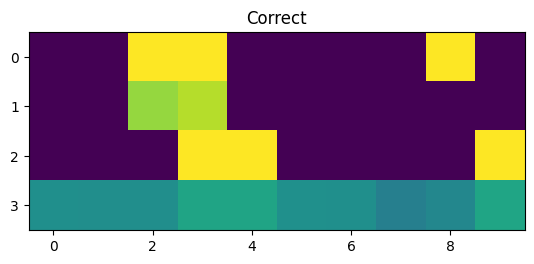

In [66]:
# test learning
disp=display(display_id=True)
for _ in range(10):
	p = patterns[random.randint(0,len(patterns)-1)]
	layer1.v.zero_()
	layer2.v.zero_()
	for i in range(10):
		layer1.inputTensor(p)
		layer2.input(layer1)
		layer1.update()
		layer1.learn()
		layer2.update()
		layer2.learn()
		plt.imshow([p,layer1.v,layer2.v,layer2.learnp-layer2.learnd+0.5], vmin=0,vmax=1)
		clear_output(True)
		plt.title("Predict")
		disp.update(plt.figure)
		plt.pause(0.1)

	for i in range(10):
		layer1.inputTensor(p)
		layer2.input(layer1)
		layer1.update()
		layer1.learn()
		layer2.update()
		layer2.v.copy_(p.roll(1))
		layer2.learn()
		plt.imshow([p,layer1.v,layer2.v,layer2.learnp-layer2.learnd+0.5], vmin=0,vmax=1)
		clear_output(True)
		plt.title("Correct")
		disp.update(plt.figure)
		plt.pause(0.1)

In [ ]:
class PredictingLayer(Layer):
	def __init__(self, shape):
		super().__init__(shape)
		self.prevSenderV = {}
	def input(self, sender):
		if not sender in self.w:
			self.w[sender] = parts.initWeights((sender.shape,self.shape))
			self.prevSenderV[sender] = torch.zeros(sender.shape)
		self.inputExcitatory += self.prevSenderV[sender] @ self.w[sender]
	def update(self, alphaCycleProgess, layerToPredict):
		super().updateV()
		if alphaCycleProgess > 0.5:
			self.v.copy_(layerToPredict)
	def updatePostAlphaCycle(self):
		for sender in self.w:
			self.prevSenderV[sender] = sender.v.clone()
	